In [1]:
import pandas as pd
import re
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# 问题1：预测租金价格时，最重要的内部和外部特征是什么？

In [2]:

base_dir = "data/"
# 读取租金数据
rent_data = pd.read_csv(base_dir + 'rent_data_SA2.csv')

# 将价格转换为数值
def extract_price(price_str):
    price_str = str(price_str).replace('$', '').replace(',', '').lower()
    price_numbers = re.findall(r'\d+\.?\d*', price_str)
    if price_numbers:
        price = float(price_numbers[0])
        # 调整按周或按月的价格
        if 'per week' in price_str or 'pw' in price_str:
            price = price * 4.34524  # 一个月的平均周数
        elif 'per month' in price_str or 'pcm' in price_str:
            pass  # 已经是按月的价格
        return price
    else:
        return np.nan

rent_data['price_numeric'] = rent_data['price'].apply(extract_price)

# 选择内部特征
rent_data_internal = rent_data[['price_numeric', 'bathrooms', 'bedrooms', 'parking', 'type', 'furnished', 'SA2_code']]

# 处理缺失值
rent_data_internal.dropna(subset=['price_numeric', 'bathrooms', 'bedrooms', 'parking', 'type', 'furnished', 'SA2_code'], inplace=True)

# 将类别变量转换为分类数据类型
rent_data_internal['type'] = rent_data_internal['type'].astype('category')
rent_data_internal['furnished'] = rent_data_internal['furnished'].astype('category')

In [3]:
# 外部特征：

# 1. 每个SA2_code的医院和学校数量
hospitals_schools = pd.read_csv(base_dir + 'hospitals_and_schools_with_SA2_code.csv')
hospitals_schools_counts = hospitals_schools.groupby('SA2_code').size().reset_index(name='num_hospitals_schools')

In [4]:
# 2. 每个SA2_code的市场数量
markets = pd.read_csv(base_dir + 'Markets_Victoria_SA2.csv')
markets_counts = markets.groupby('SA2_code').size().reset_index(name='num_markets')

In [5]:
# 3. 每个SA2_code的火车站数量
train_stations = pd.read_csv(base_dir + 'Train_Victoria_SA2.csv')
train_stations_counts = train_stations.groupby('SA2_code').size().reset_index(name='num_train_stations')

In [6]:
# 4. 每个SA2_code的犯罪率
# crime_data = pd.read_csv(base_dir + 'victoria_crime_data_with_sa2_and_rates.csv')
# crime_rates = crime_data[['SA2_code', 'Rate per 100,000 population']]
# crime_rates.rename(columns={'SA2_code': 'SA2_code', 'Rate per 100,000 population': 'crime_rate_per_100k'}, inplace=True)
# crime_rates = crime_rates.drop_duplicates(subset='SA2_code')

# 平均逻辑
crime_data = pd.read_csv(base_dir + 'victoria_crime_data_with_sa2_and_rates.csv')

# 将 'Incident Recorded' 和 'Rate per 100,000 population' 转换为数值类型（如果需要）
crime_data['Incidents Recorded'] = pd.to_numeric(crime_data['Incidents Recorded'], errors='coerce')
crime_data['Rate per 100,000 population'] = pd.to_numeric(crime_data['Rate per 100,000 population'], errors='coerce')

# 按 SA2_code 分组，计算 'Incident Recorded' 和 'Rate per 100,000 population' 的平均值
crime_rates = crime_data.groupby('SA2_code').agg({
    'Incidents Recorded': 'mean',
    'Rate per 100,000 population': 'mean'
}).reset_index()

# 重命名列
crime_rates.rename(columns={
    'SA2_code': 'SA2_code',
    'Incidents Recorded': 'avg_incidents_recorded',
    'Rate per 100,000 population': 'avg_crime_rate_per_100k'
}, inplace=True)

In [7]:
# 合并外部特征到租金数据中
rent_data_external = rent_data_internal.merge(hospitals_schools_counts, on='SA2_code', how='left')
rent_data_external = rent_data_external.merge(markets_counts, on='SA2_code', how='left')
rent_data_external = rent_data_external.merge(train_stations_counts, on='SA2_code', how='left')
rent_data_external = rent_data_external.merge(crime_rates[['SA2_code', 'avg_crime_rate_per_100k']], on='SA2_code', how='left')

In [8]:
# # 填充外部特征中的缺失值
# rent_data_external['num_hospitals_schools'].fillna(0, inplace=True)
# rent_data_external['num_markets'].fillna(0, inplace=True)
# rent_data_external['num_train_stations'].fillna(0, inplace=True)
# rent_data_external['crime_rate_per_100k'].fillna(rent_data_external['crime_rate_per_100k'].mean(), inplace=True)

In [9]:
# 将缺失值用均值填充
rent_data_external['num_hospitals_schools'].fillna(rent_data_external['num_hospitals_schools'].mean(), inplace=True)
rent_data_external['num_markets'].fillna(rent_data_external['num_markets'].mean(), inplace=True)
rent_data_external['num_train_stations'].fillna(rent_data_external['num_train_stations'].mean(), inplace=True)
rent_data_external['avg_crime_rate_per_100k'].fillna(rent_data_external['avg_crime_rate_per_100k'].mean(), inplace=True)

In [10]:
# 编码类别变量
rent_data_encoded = pd.get_dummies(rent_data_external, columns=['type', 'furnished'], drop_first=True)

# 定义特征和目标变量
X = rent_data_encoded.drop(['price_numeric', 'SA2_code'], axis=1)
y = rent_data_encoded['price_numeric']

In [11]:
# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# 训练随机森林回归模型
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# 获取特征重要性
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# 输出最重要的前10个特征
print("预测租金价格的最重要特征前10名：")
print(feature_importances.head(10))

预测租金价格的最重要特征前10名：
bedrooms                        0.311723
avg_crime_rate_per_100k         0.259337
parking                         0.081498
bathrooms                       0.064071
type_Apartment / Unit / Flat    0.059568
num_hospitals_schools           0.057501
num_markets                     0.042903
furnished_True                  0.035537
type_House                      0.034204
num_train_stations              0.020949
dtype: float64


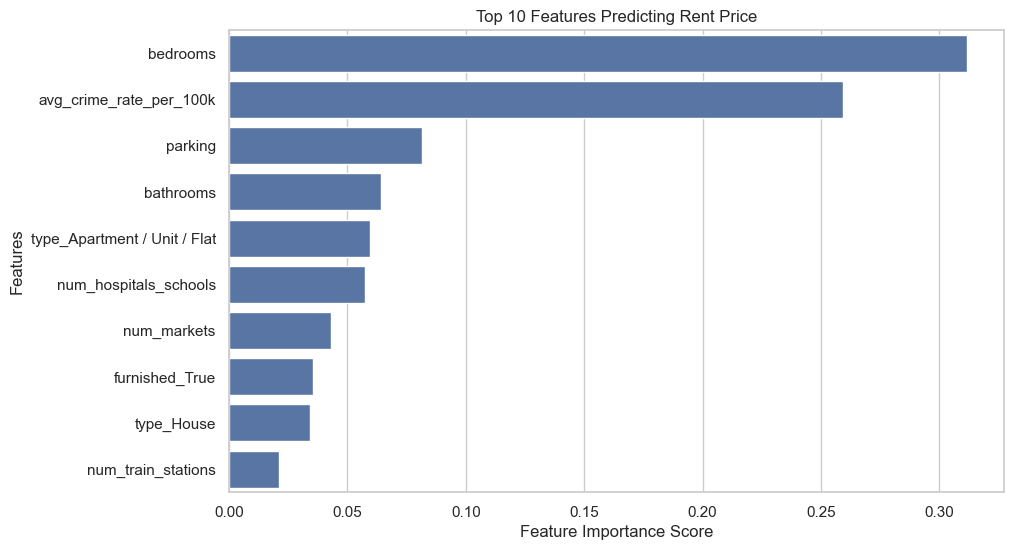

In [14]:
# 绘制特征重要性条形图
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)
plt.title("Top 10 Features Predicting Rent Price")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

# 问题2：预测增长率最高的前10个郊区是哪些？

In [15]:
# 因缺乏时间序列数据，将增长潜力基于外部特征来估计

# 计算每个SA2_code的平均租金价格
avg_rent_per_SA2 = rent_data_external.groupby('SA2_code')['price_numeric'].mean().reset_index()
avg_rent_per_SA2.rename(columns={'price_numeric': 'avg_rent_price'}, inplace=True)

# 获取外部特征在SA2_code级别的数据
external_features_per_SA2 = rent_data_external.groupby('SA2_code').agg({
    'num_hospitals_schools': 'mean',
    'num_markets': 'mean',
    'num_train_stations': 'mean',
    'avg_crime_rate_per_100k': 'mean'
}).reset_index()

In [16]:
len(set(avg_rent_per_SA2["SA2_code"]))

500

In [17]:
len(set(external_features_per_SA2["SA2_code"]))

500

In [18]:
# 合并平均租金价格和外部特征
SA2_data = avg_rent_per_SA2.merge(external_features_per_SA2, on='SA2_code', how='left')

In [19]:
# 计算增长潜力得分
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
SA2_features = SA2_data[['avg_rent_price', 'num_hospitals_schools', 'num_markets', 'num_train_stations', 'avg_crime_rate_per_100k']]
SA2_features_scaled = scaler.fit_transform(SA2_features)
SA2_features_scaled = pd.DataFrame(SA2_features_scaled, columns=SA2_features.columns)

In [20]:
# 假设低租金、高便利设施、低犯罪率的地区具有更高的增长潜力
SA2_features_scaled['amenities_score'] = SA2_features_scaled['num_hospitals_schools'] + SA2_features_scaled['num_markets'] + SA2_features_scaled['num_train_stations']
SA2_features_scaled['crime_score'] = 1 - SA2_features_scaled['avg_crime_rate_per_100k']  # 犯罪率越低越好
SA2_features_scaled['low_rent_score'] = 1 - SA2_features_scaled['avg_rent_price']  # 租金越低，增长潜力越高

In [21]:
# 计算增长潜力得分，可以调整系数
SA2_features_scaled['growth_potential_score'] = 1*SA2_features_scaled['amenities_score'] + 1*SA2_features_scaled['crime_score'] + 1*SA2_features_scaled['low_rent_score']

In [22]:
# 添加SA2_code
SA2_features_scaled['SA2_code'] = SA2_data['SA2_code']

In [23]:
# 从 crime_data 中创建 SA2_code 到 SA2_NAME21 的映射
sa2_name_mapping = crime_data[['SA2_code', 'SA2_NAME21']].drop_duplicates(subset='SA2_code')

# 确保 sa2_name_mapping 中的 SA2_code 是唯一的
print("sa2_name_mapping 中的行数（应为唯一的 SA2_code 数量）：", sa2_name_mapping['SA2_code'].nunique())

sa2_name_mapping 中的行数（应为唯一的 SA2_code 数量）： 528


In [24]:
# 将 SA2_name 合并到 SA2_features_scaled 中
SA2_features_scaled = SA2_features_scaled.merge(sa2_name_mapping, on='SA2_code', how='left')

# 检查合并后的行数是否与合并前一致
print("合并后的 SA2_features_scaled 行数：", len(SA2_features_scaled))

合并后的 SA2_features_scaled 行数： 500


In [25]:
SA2_features_scaled

,avg_rent_price,num_hospitals_schools,num_markets,num_train_stations,avg_crime_rate_per_100k,amenities_score,crime_score,low_rent_score,growth_potential_score,SA2_code,SA2_NAME21
0,0.058341,0.461227,0.137534,0.044212,0.181700,0.642972,0.818300,0.941659,2.402931,109031185.0,Tocumwal - Finley - Jerilderie
1,0.054911,0.127907,0.137534,0.044212,0.170803,0.309653,0.829197,0.945089,2.083938,201011001.0,Alfredton
2,0.048052,0.104651,0.137534,0.044212,0.372146,0.286397,0.627854,0.951948,1.866199,201011002.0,Ballarat
3,0.078204,0.461227,0.137534,0.044212,0.168696,0.642972,0.831304,0.921796,2.396072,201011005.0,Buninyong
4,0.061628,0.461227,0.000000,0.044212,0.170803,0.505439,0.829197,0.938372,2.273007,201011006.0,Delacombe
...,...,...,...,...,...,...,...,...,...,...,...
495,0.031678,0.461227,0.137534,0.044212,0.052345,0.642972,0.947655,0.968322,2.558949,217031476.0,Otway
496,0.013711,0.461227,0.137534,0.044212,0.200766,0.642972,0.799234,0.986289,2.428496,217041477.0,Moyne - East
497,0.032933,0.461227,0.137534,0.044212,0.196917,0.642972,0.803083,0.967067,2.413122,217041478.0,Moyne - West
498,0.030270,0.461227,0.137534,0.044212,0.163868,0.642972,0.836132,0.969730,2.448834,217041479.0,Warrnambool - North


In [26]:
# 按增长潜力得分排序，取前10名
top_10_SA2_growth = SA2_features_scaled[['SA2_code', 'SA2_NAME21', 'avg_rent_price', 'growth_potential_score']].sort_values(by='growth_potential_score', ascending=False).head(10)

print("\n预测增长率最高的前10个郊区：")
print(top_10_SA2_growth)


预测增长率最高的前10个郊区：
        SA2_code         SA2_NAME21  avg_rent_price  growth_potential_score
462  215011394.0       Yarriambiack        0.036075                3.304005
465  215021398.0  Mildura Surrounds        0.002820                3.217817
459  215011390.0       Nhill Region        0.005042                3.184643
363  212041563.0  Dandenong - North        0.076993                2.957404
13   201021011.0         Daylesford        0.122531                2.944229
34   202031033.0             Loddon        0.001990                2.928332
252  210021232.0           Gisborne        0.099878                2.911222
29   202021027.0        Castlemaine        0.109738                2.830882
454  214021592.0  Mornington - West        0.161521                2.820528
232  209041224.0             Wallan        0.088444                2.814445


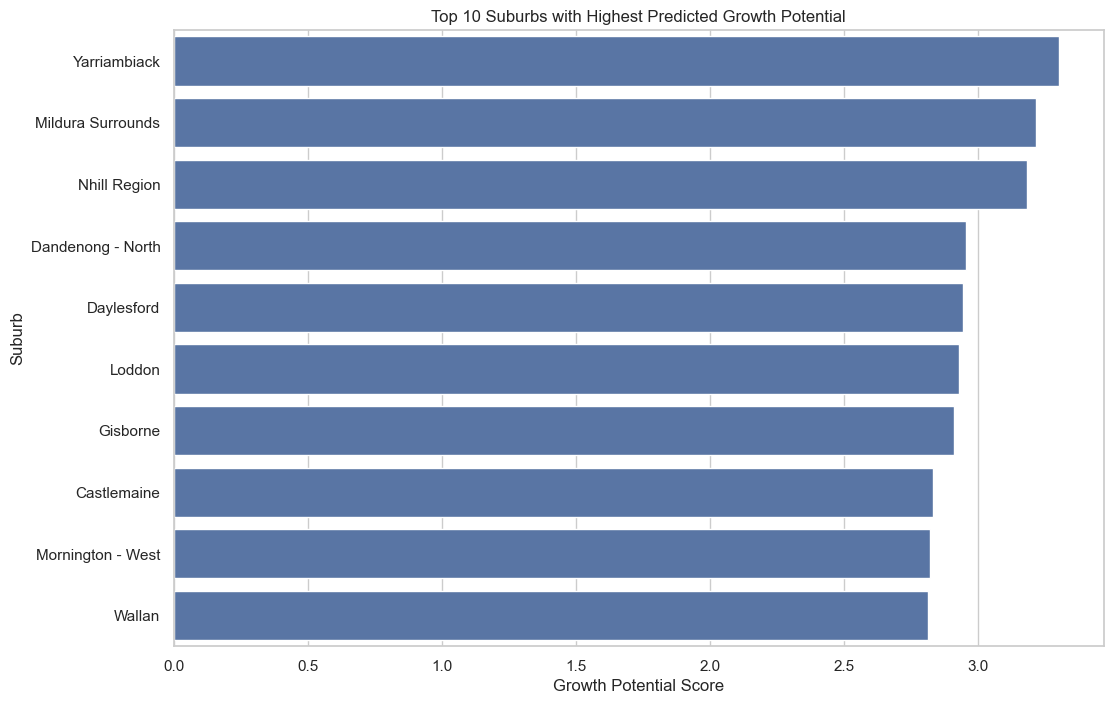

In [27]:
# 绘制增长潜力得分的条形图
plt.figure(figsize=(12, 8))
sns.barplot(x='growth_potential_score', y='SA2_NAME21', data=top_10_SA2_growth)
plt.title("Top 10 Suburbs with Highest Predicted Growth Potential")
plt.xlabel("Growth Potential Score")
plt.ylabel("Suburb")
plt.show()

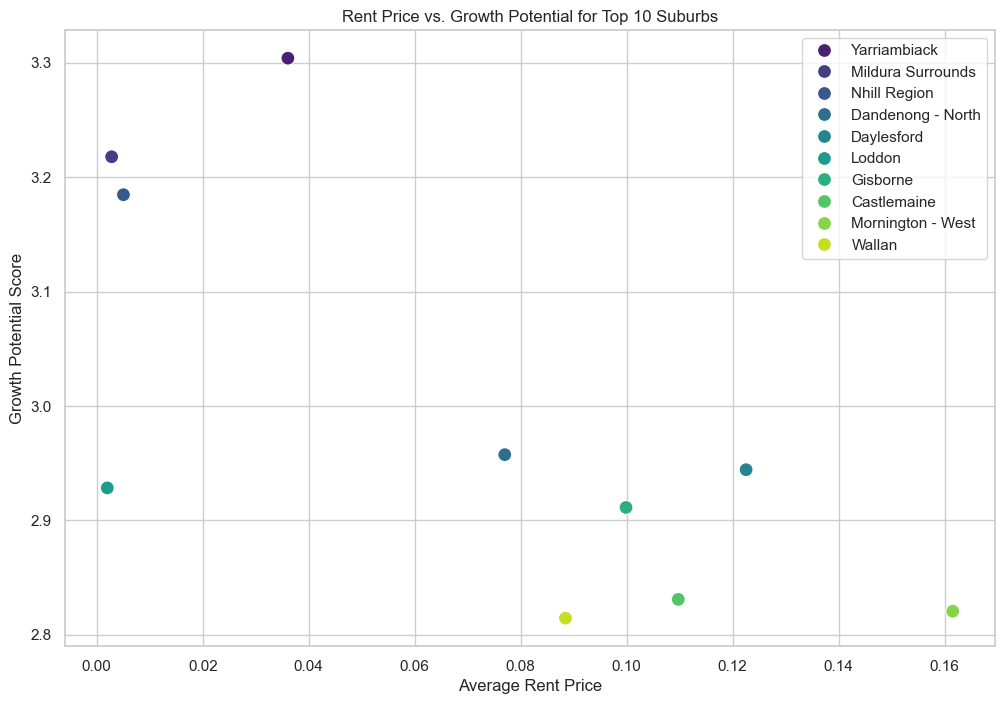

In [28]:
# 绘制租金价格与增长潜力的散点图
plt.figure(figsize=(12, 8))
sns.scatterplot(x='avg_rent_price', y='growth_potential_score', hue='SA2_NAME21', data=top_10_SA2_growth, palette="viridis", s=100)
plt.title("Rent Price vs. Growth Potential for Top 10 Suburbs")
plt.xlabel("Average Rent Price")
plt.ylabel("Growth Potential Score")
plt.legend(loc='best')
plt.show()

# 问题3：根据你选择的指标，最宜居且价格合理的郊区是哪些？

In [29]:
# 计算可负担性得分
median_rent_price = SA2_data['avg_rent_price'].median()
SA2_data['affordability_score'] = SA2_data['avg_rent_price'].apply(lambda x: 1 if x <= median_rent_price else 0)

In [30]:
# 规范化便利设施得分和犯罪得分
SA2_features_scaled['amenities_score_norm'] = SA2_features_scaled['amenities_score'] / SA2_features_scaled['amenities_score'].max()
SA2_features_scaled['crime_score_norm'] = SA2_features_scaled['crime_score'] / SA2_features_scaled['crime_score'].max()

In [31]:
# 计算宜居性得分
SA2_features_scaled['livability_score'] = SA2_features_scaled['amenities_score_norm'] + SA2_features_scaled['crime_score_norm'] + SA2_data['affordability_score']

In [32]:
# 按宜居性得分排序，取前10名
top_livable_suburbs = SA2_features_scaled[['SA2_code', 'SA2_NAME21', 'avg_rent_price', 'livability_score']].sort_values(by='livability_score', ascending=False).head(10)

print("\n最宜居且价格合理的郊区：")
print(top_livable_suburbs)


最宜居且价格合理的郊区：
        SA2_code             SA2_NAME21  avg_rent_price  livability_score
462  215011394.0           Yarriambiack        0.036075          2.741319
465  215021398.0      Mildura Surrounds        0.002820          2.684295
459  215011390.0           Nhill Region        0.005042          2.653343
363  212041563.0      Dandenong - North        0.076993          2.538680
232  209041224.0                 Wallan        0.088444          2.501584
34   202031033.0                 Loddon        0.001990          2.495588
57   204011054.0              Alexandra        0.059661          2.482104
297  211031266.0               Ringwood        0.069586          2.394630
12   201021010.0      Creswick - Clunes        0.068606          2.386189
19   201031017.0  Maryborough Surrounds        0.064130          2.385626


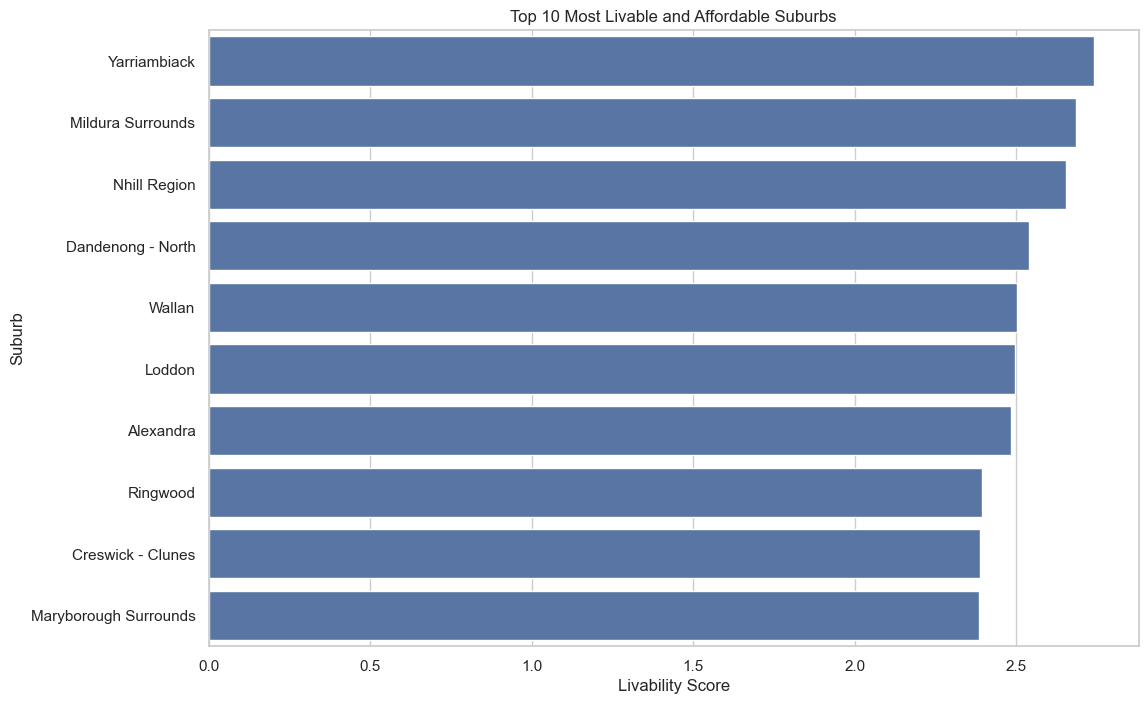

In [33]:
# 绘制宜居性得分的条形图
plt.figure(figsize=(12, 8))
sns.barplot(x='livability_score', y='SA2_NAME21', data=top_livable_suburbs)
plt.title("Top 10 Most Livable and Affordable Suburbs")
plt.xlabel("Livability Score")
plt.ylabel("Suburb")
plt.show()

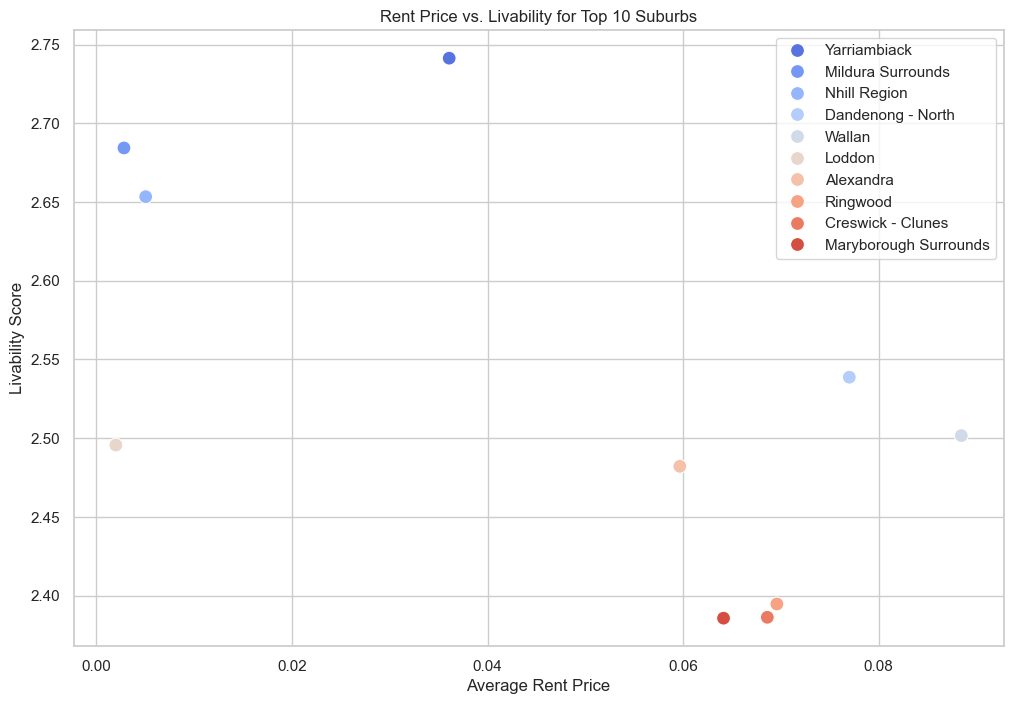

In [34]:
# 绘制租金价格与宜居性得分的散点图
plt.figure(figsize=(12, 8))
sns.scatterplot(x='avg_rent_price', y='livability_score', hue='SA2_NAME21', data=top_livable_suburbs, palette="coolwarm", s=100)
plt.title("Rent Price vs. Livability for Top 10 Suburbs")
plt.xlabel("Average Rent Price")
plt.ylabel("Livability Score")
plt.legend(loc='best')
plt.show()